In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 3.26 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=21ab052530ebf5ca4bd2ebd0272a19e231927fd5f5060a605e6d0e7611f0c531
  Stored in directory: /tmp/pip-ephem-wheel-cache-71yyhyvp/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


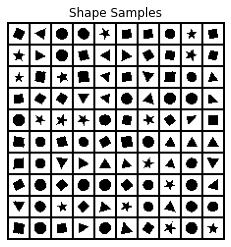

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from torch import nn
from torch.utils import data
from torch import optim as opt
from tqdm import tqdm
import torch
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from torch.utils.data import Dataset, DataLoader
from tqdm import trange, tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, 
                        stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

In [7]:
class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

In [8]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [9]:
class Residual(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.model = nn.Sequential(
            ConvB(in_channels, in_channels // 2, 1, **kwargs), 
            nn.ReLU(), 
            ConvB(in_channels // 2, in_channels // 2, 7, padding=3, **kwargs), 
            nn.ReLU(), 
            ConvB(in_channels // 2, in_channels, 1, **kwargs),
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.model(x)
        return out + x

In [10]:
def collate_fn(x): 
    x = np.array(x).transpose(0, 3, 1, 2)
    x = torch.tensor(x, dtype=torch.long)

    return x 

In [20]:
class FlowPixelCNN(nn.Module):
    def __init__(self, 
                 input_shape, 
                 n_colors=10,
                 n_filters=120, 
                 kernel_size=7, 
                 base_dist='uniform'):
        
        super().__init__()
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.model = nn.Sequential(*self.get_model())

        if base_dist=='uniform':
            self.bdist = Uniform(torch.Tensor([0]).to(device), torch.Tensor([1]).to(device))
        elif base_dist == 'beta':
            self.bdist = Beta(torch.Tensor([2]).to(device), torch.Tensor([2]).to(device))

    def get_model(self): 
        C, H, W = self.input_shape
        model = [ConvA(C, self.n_filters, self.kernel_size, padding=self.kernel_size // 2), 
                 LayerNorm(self.n_filters), 
                 nn.ReLU()]

        for _ in range(8): 
            model.extend([Residual(self.n_filters), LayerNorm(self.n_filters), nn.ReLU()])

        model.extend([ConvB(self.n_filters, self.n_filters, 1), 
                      nn.ReLU(), 
                      ConvB(self.n_filters, C * 3 * self.n_colors, 1)])
        
        return model
    
    def forward(self, x):
        out = self.model(x)
        return out.view(x.shape[0], 3 * self.n_colors, *self.input_shape)

    def test(self, test_loader):
        self.eval()
        total_loss = 0
        tc = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device).float()
                loss = self.nll(batch)
                total_loss += loss * batch.shape[0]
                tc += batch.shape[0]
        return total_loss.item() / tc

    def fit(self, train_data, test_data, num_epochs=20, 
            lr=1e-3, batch_size=128):
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        test_loader = data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = []

        test_losses.append(self.test(test_loader))

        for epoch in tqdm(range(num_epochs), "Train epoch"):
            self.train()
            for batch in train_loader:
                batch = batch.to(device).float()
                loss = self.nll(batch)
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_losses.append(loss.item())
            test_losses.append(self.test(test_loader))

        return train_losses, test_losses

    def flow(self, x):
        mu, log_s, log_w = torch.chunk(self(x), 3, dim=1)

        w = F.softmax(log_w, dim=1)

        dist = Normal(mu, log_s.exp())

        xr  = x.unsqueeze(1).repeat(1, self.n_colors, 1, 1, 1)
        
        z = (dist.cdf(xr) * w).sum(dim=1)

        log_det = (dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return z, log_det


    def inverse(self, z):
        raise NotImplementedError()

    def pixel_inverse_flow(self, w, mu, log_s):
        batch_size = w.shape[0]
        z = self.bdist.sample((batch_size,))

        pixel_values = []
        for i in range(batch_size):
            dist = Normal(mu[i], log_s[i].exp())
            def f(x):
                x = torch.FloatTensor(np.repeat(x, self.n_colors)).to(device)
                return w[i].dot(dist.cdf(x)) - z[i]
            
            pixel_values.append(bisect(f, -20, 20))
        
        return torch.FloatTensor(pixel_values).to(device)

    def sample(self, n=100):
        with torch.no_grad():
            c, h, w = self.input_shape
            samples = torch.zeros((n, c, h, w), device=device)
            for y in trange(h, desc="Sampling"):
                for x in range(w):
                    for i in range(c):
                        w, mu, log_s = torch.chunk(self(samples)[:, :, i, y, x], 3, dim=1)
                        w = F.softmax(w, dim=1)
                        samples[:, i, y, x] = self.pixel_inverse_flow(w, mu, log_s)

        return torch.clip(samples, 0, 1).permute(0, 2, 3, 1).cpu().numpy()

    def log_prob(self, x):
        z, log_det = self.flow(x)
        log_prob = self.bdist.log_prob(z)
        return log_prob + log_det

    def nll(self, x):
        return -self.log_prob(x).mean()



In [21]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """

  batch_size = 128
  
  _, h, w, c = train_data.shape
  image_new_shape = (c, h, w)

  model = FlowPixelCNN(image_new_shape, n_colors=10).to(device)

  train_losses, test_losses = model.fit(train_data, test_data, num_epochs=20, 
            lr=1e-3, batch_size=batch_size)
  
  return train_losses, test_losses, model.sample()

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



In [22]:
q1_save_results(q1)

Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


NameError: ignored